In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import optimizer_preprint as fitACi
import numpy as np
import torch
def getRMSE(predicted, measured):
    return np.sqrt(torch.mean((predicted - measured) ** 2))
def getR(predicted, measured):
    return np.corrcoef(predicted, measured)[0, 1]

In [2]:
pathlcddfs = 'dfMAGIC043.csv'
pdlMAGIC043 = pd.read_csv(pathlcddfs)
print(pdlMAGIC043.columns)

Index(['Date', 'Sample ID', 'Plot', 'time', 'elapsed', 'hhmmss', 'averaging',
       'TIME', 'E', 'Emm',
       ...
       'Ts', 'Tr', 'CO2_%', 'Desiccant_%', 'Humidifier_%', 'Txchg_sp',
       'CO2_r_sp', 'H2O_r_sp', 'SS_s', 'SS_r'],
      dtype='object', length=212)


In [3]:
pathlcd = 'pdlicors.xlsx'
xlsnames = pd.ExcelFile(pathlcd).sheet_names
print(xlsnames)
pdlcdall = []
for xlsname in xlsnames[0:2]:
    pdlcd = pd.read_excel(pathlcd, sheet_name=xlsname)
    # check if pdlcdall is empty
    if len(pdlcdall) == 0:
        pdlcdall = pdlcd
    else:
        pdlcdall = pd.concat([pdlcdall, pdlcd], ignore_index=True)
    print(pdlcd.columns)

['sheet_1', 'sheet_2', 'sheet_3', 'sheet_4', 'sheet_5', 'sheet_6', 'sheet_7', 'sheet_8', 'sheet_9', 'sheet_10', 'sheet_11']
Index(['Date', 'Plot', 'Magic', 'Sample ID', 'Field ID', 'bandR', 'bandG',
       'bandB', 'NIR', 'A', 'Ci', 'Tleaf', 'gsw', 'Qin', 'Ca', 'RHcham',
       'VPDleaf', 'Pa', 'Nitrogen (%)'],
      dtype='object')
Index(['Date', 'Plot', 'Magic', 'Sample ID', 'Field ID', 'bandR', 'bandG',
       'bandB', 'NIR', 'A', 'Ci', 'Tleaf', 'gsw', 'Qin', 'Ca', 'RHcham',
       'VPDleaf', 'Pa', 'Nitrogen (%)'],
      dtype='object')


In [4]:
# Get structured LiCor data
# lcd = fitACi.initD.initLicordata(pdlcdall, preprocess=True)
lcd = fitACi.initD.initLicordata(pdlMAGIC043, preprocess=True)
lcd.setLightRespID(118) # set the light response ID
print(lcd.num_PIDs)


Done reading: 12 A/Ci curves; 4990 data points
1


In [7]:
# Define the device where the model is run
device_fit = 'cpu'
lcd.todevice(torch.device(device_fit)) # if device is cuda, then execute this line
fvcbmMAGIC043 = fitACi.initM.FvCB(lcd, LightResp_type = 1, TempResp_type = 1, onefit = False, fitgm=True)
fvcbmMAGIC043,recordweights = fitACi.run(fvcbmMAGIC043,learn_rate= 0.08, device=device_fit, maxiteration = 10000, minloss= 1,recordweightsTF=True)
fvcbmMAGIC043.eval()

Light response type 1: alpha will be fitted.
Temperature response type 1: dHa_Vcmax, dHa_Jmax, dHa_TPU will be fitted.
Loss at iter 199: 116.4920
Loss at iter 399: 67.0674
Loss at iter 599: 44.3725
Loss at iter 799: 33.3776
Loss at iter 999: 26.9281
Loss at iter 1199: 22.0409
Loss at iter 1399: 18.2308
Loss at iter 1599: 15.5419
Loss at iter 1799: 14.0786
Loss at iter 1999: 11.7770
Loss at iter 2199: 10.4670
Loss at iter 2399: 9.7642
Loss at iter 2599: 8.6942
Loss at iter 2799: 9.4360
Loss at iter 2999: 7.7136
Loss at iter 3199: 8.1791
Loss at iter 3399: 7.9174
Loss at iter 3599: 6.8212
Loss at iter 3799: 7.0265
Loss at iter 3999: 6.4923
Loss at iter 4199: 8.1219
Loss at iter 4399: 8.7160
Loss at iter 4599: 6.7180
Loss at iter 4799: 6.8167
Loss at iter 4999: 6.0785
Loss at iter 5199: 6.1894
Loss at iter 5399: 5.9373
Loss at iter 5599: 5.7613
Loss at iter 5799: 5.6484
Loss at iter 5999: 5.9396
Loss at iter 6199: 5.5194
Loss at iter 6399: 5.9591
Loss at iter 6599: 5.3956
Loss at iter 679

FvCB(
  (LightResponse): LightResponse()
  (TempResponse): TemperatureResponse(
    (TRparam): initTRparameters()
  )
)

In [9]:
print(fvcbmMAGIC043.TempResponse.getdS('Vcmax'))

AttributeError: 'TemperatureResponse' object has no attribute 'dHd_Vcmax'

alphaG_r
Vcmax25
Jmax25
TPU25
Rd25
gm
LightResponse.alpha
TempResponse.dHa_Vcmax
TempResponse.dHa_Jmax
TempResponse.dHa_TPU


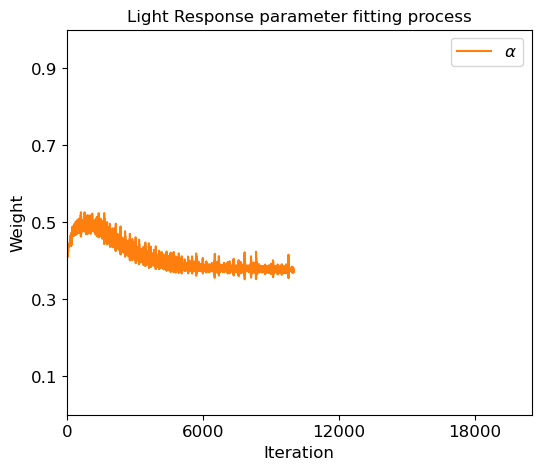

In [10]:
# tracking the fitting process
fontsz = 12
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, 10))
plt.figure(figsize=(6, 5))
for label, weights in recordweights.items():
    print(label)
    if label == 'LightResponse.alpha':
        plt.plot(weights,label=r'$\alpha$',color=colors[1])
    if label == 'LightResponse.theta':
        plt.plot(weights,label=r'$\theta$',color=colors[2])
plt.title('Light Response parameter fitting process', fontsize=fontsz)
plt.legend(fontsize=fontsz)
plt.xlim(0, 20500)
plt.ylim(0, 1)
plt.xlabel('Iteration', fontsize=fontsz)
plt.ylabel('Weight', fontsize=fontsz)
plt.xticks([0, 6000, 12000, 18000],fontsize=fontsz)
plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9],fontsize=fontsz)
plt.show()
plt.close()

In [ ]:
for label, weights in recordweights.items():
    if 'Vcmax25' in label:
        print(weights.shape)
        plt.plot(weights,label='Rd25')

In [12]:
PIDsaa = np.array(lcd.PIDs)
print(PIDsaa)
PID = 0
out = np.where(PIDsaa == PID)[0]
print(out)

[0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[ 0  4  5  6  8 11 13 14 15 19 20]


alphaG_r
Vcmax25
Jmax25
TPU25
Rd25
gm
TempResponse.dHa_Vcmax
TempResponse.dHa_Jmax
TempResponse.dHa_TPU
TempResponse.Topt_Vcmax
TempResponse.Topt_Jmax
TempResponse.Topt_TPU


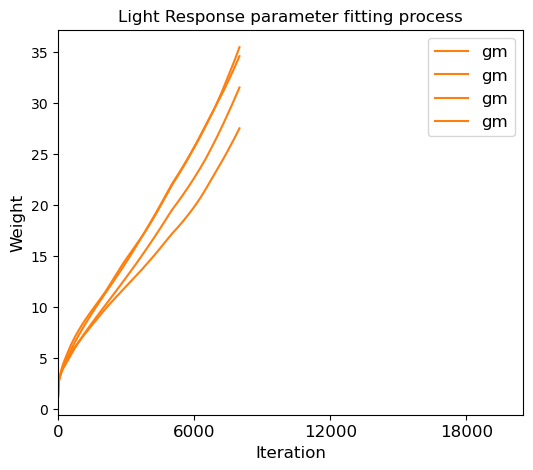

In [14]:
# tracking the fitting process
fontsz = 12
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, 10))
plt.figure(figsize=(6, 5))
for label, weights in recordweights.items():
    print(label)
    if label == 'gm':
        plt.plot(weights,label='gm',color=colors[1])
plt.title('Light Response parameter fitting process', fontsize=fontsz)
plt.legend(fontsize=fontsz)
plt.xlim(0, 20500)
# plt.ylim(0, 1)
plt.xlabel('Iteration', fontsize=fontsz)
plt.ylabel('Weight', fontsize=fontsz)
plt.xticks([0, 6000, 12000, 18000],fontsize=fontsz)
# plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9],fontsize=fontsz)
plt.show()
plt.close()

Parameter containing:
tensor([35.4583, 27.5103, 34.5835, 31.5118], requires_grad=True)


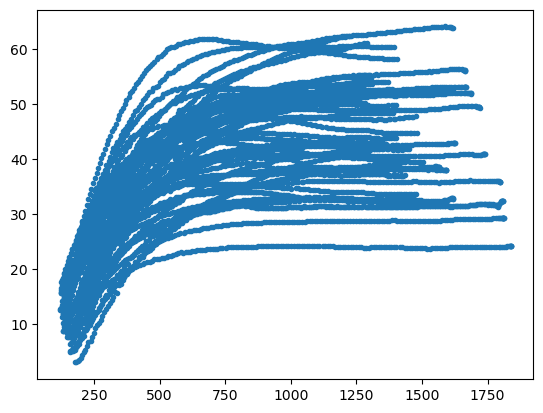

In [13]:
Cc = lcd.Ci-lcd.A/9
print(fvcbmMAGIC043.gm)
plt.plot(Cc.detach().numpy(),lcd.A.detach().numpy(),'.')

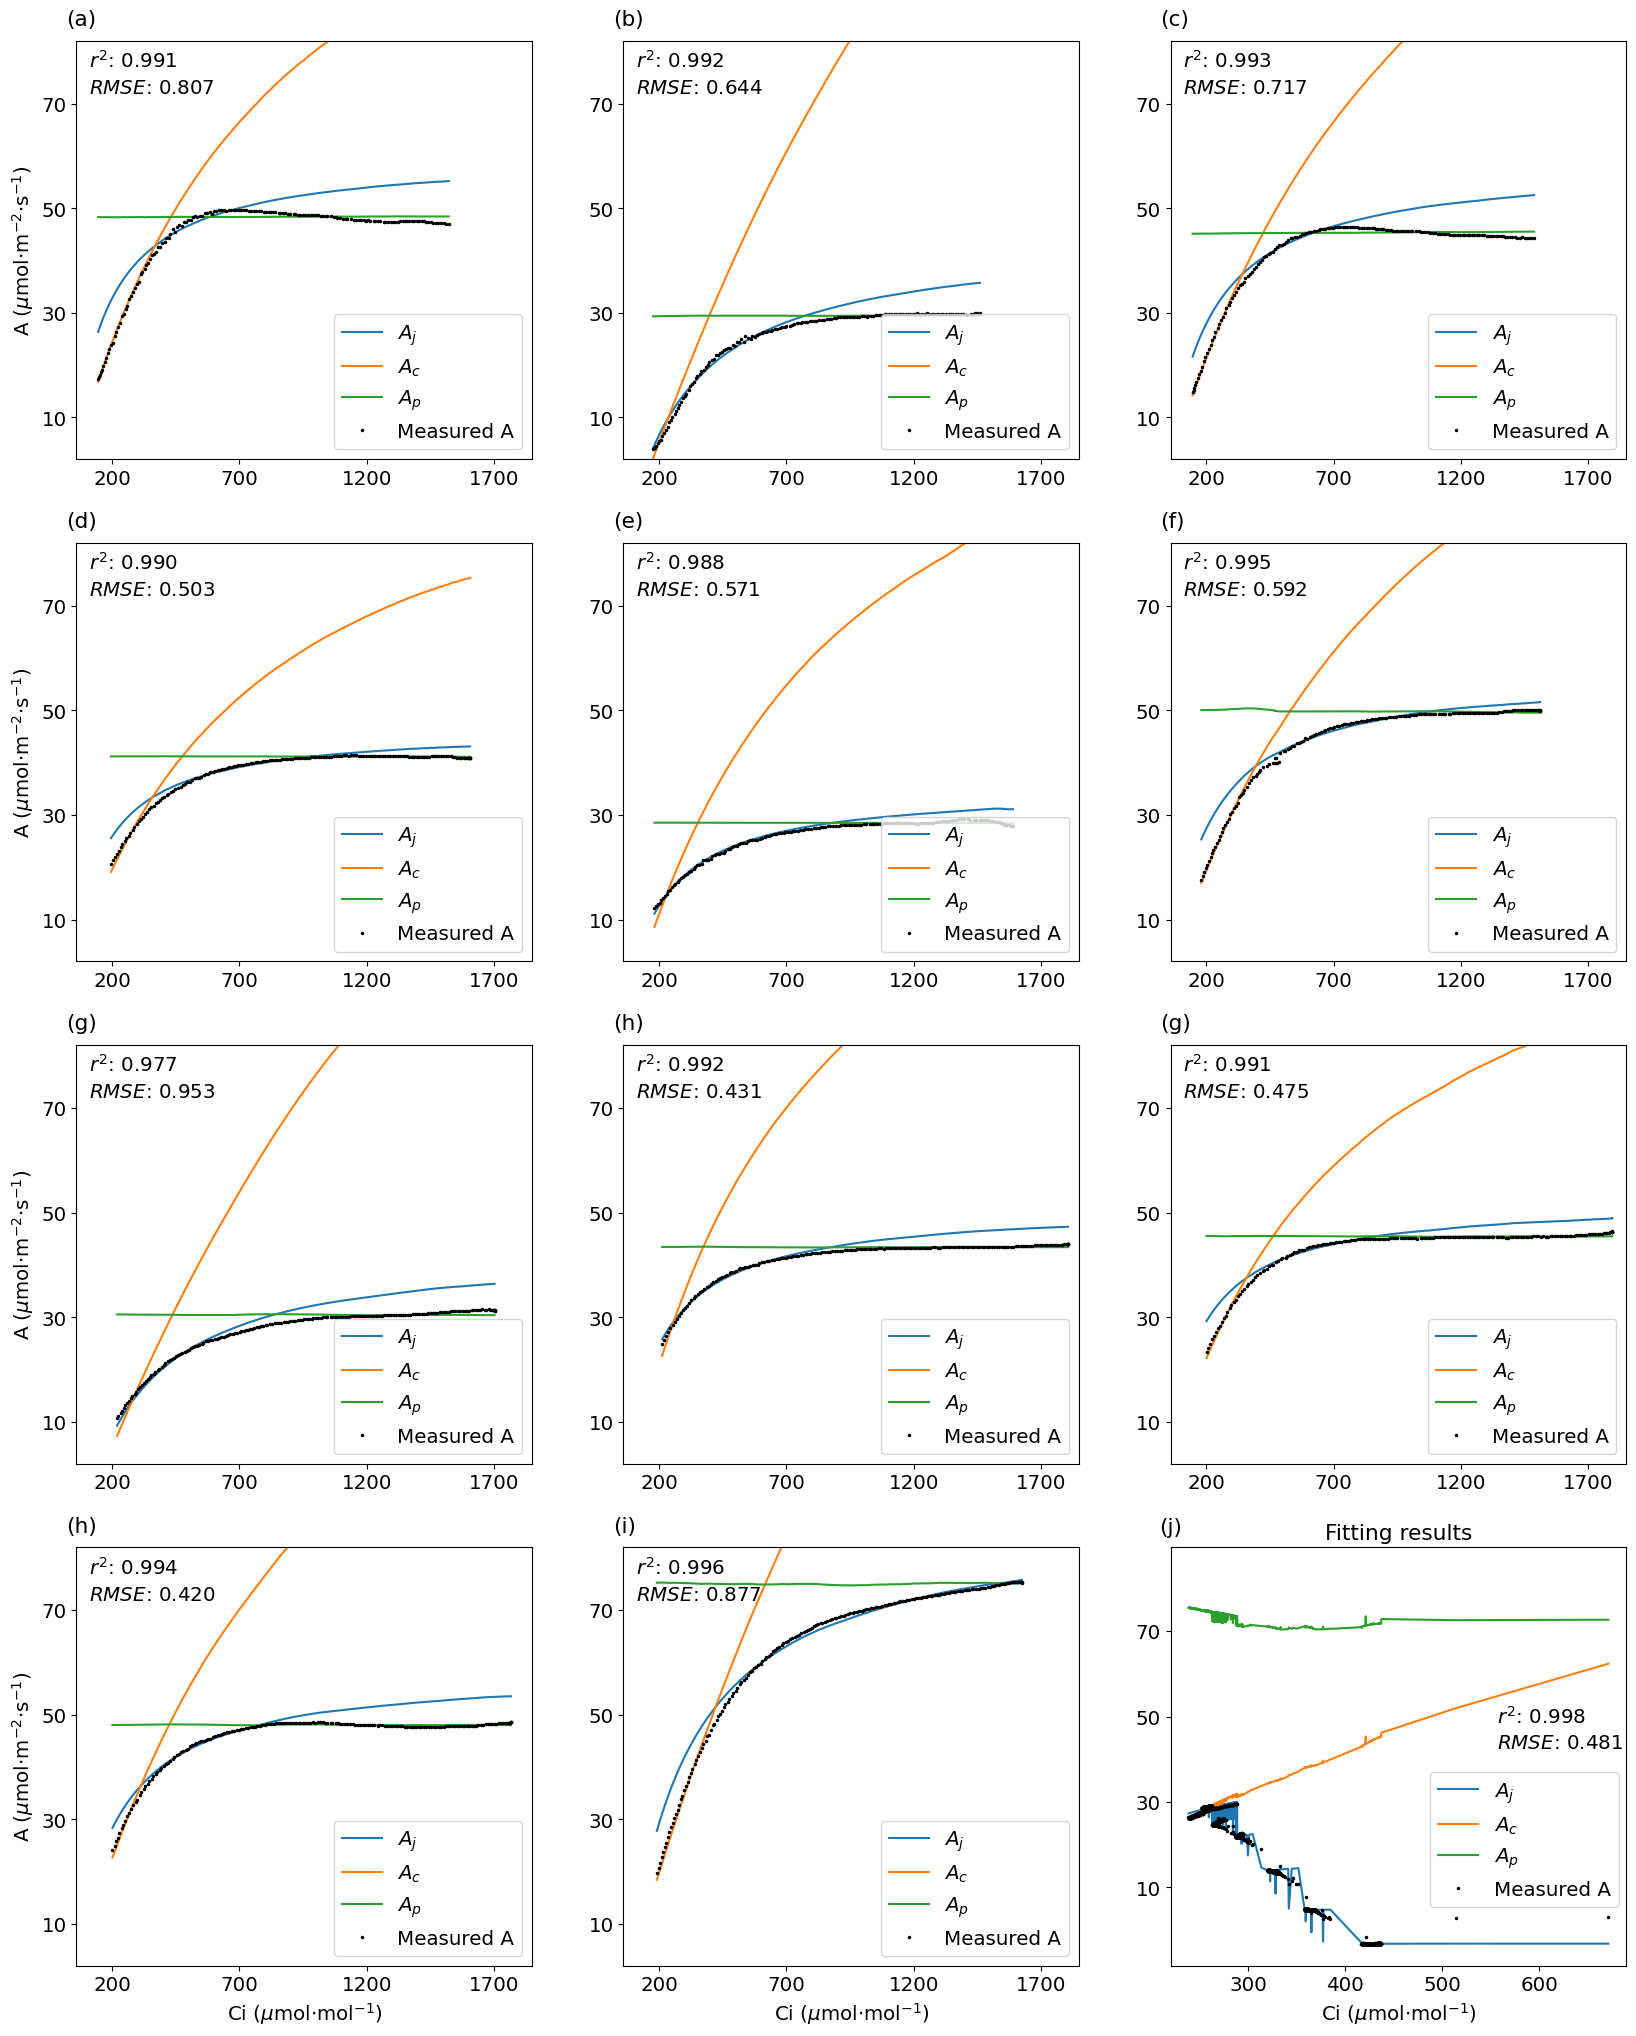

RMSE:  0.6231308690353488
R2:  0.9918123913696882


In [21]:
fontsz = 13
abcdlst = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(g)', '(h)', '(i)', '(j)']

fvcbmMAGIC043.eval()
A, Ac, Aj, Ap, Gamma = fvcbmMAGIC043()
A_fn, mask_valiTPU = fitACi.getVadlidTPU(fvcbmMAGIC043, lcd, 0.6)
rmse_all = np.array([])
r2_all = np.array([])

# get a color map
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, lcd.num))

fig, axs = plt.subplots(4, 3, figsize=(20, 25))  # 6 rows, 2 columns

for i in range(lcd.num):
    ax = axs[i // 3, i % 3]
    indices_i = lcd.getIndices(lcd.IDs[i])
    pred_A = A[indices_i]
    pred_A = pred_A.cpu().detach()
    measured_A_i, Ci_i, Q_i, Tlf_i = lcd.getDatabyID(lcd.IDs[i])
    if not lcd.mask_lightresp[i]:
        ax.plot(Ci_i, Aj[lcd.indices[i]:lcd.indices[i] + lcd.lengths[i]].cpu().detach(), label='$A_j$')
        ax.plot(Ci_i, Ac[lcd.indices[i]:lcd.indices[i] + lcd.lengths[i]].cpu().detach(), label='$A_c$')
        if mask_valiTPU[i]:
            ax.plot(Ci_i, Ap[lcd.indices[i]:lcd.indices[i] + lcd.lengths[i]].cpu().detach(), label='$A_p$')
    else:
        ax.plot(Ci_i, Aj[indices_i].cpu().detach(), label='$A_j$', markersize=3)
        ax.plot(Ci_i, Ac[indices_i].cpu().detach(), label='$A_c$', markersize=3)
        ax.plot(Ci_i, Ap[indices_i].cpu().detach(), label='$A_p$', markersize=3)
    ax.plot(Ci_i, measured_A_i, '.k', markersize=3, label='Measured A')
    
    # get the RMSE
    rmse_i = getRMSE(pred_A, measured_A_i)
    rmse_all = np.append(rmse_all, rmse_i)
    r_i = getR(pred_A, measured_A_i)
    r2_i = r_i ** 2
    r2_all = np.append(r2_all, r2_i)

    if lcd.mask_lightresp[i]:
        ax.text(208, 93, abcdlst[i], fontsize=fontsz * 1.2)
        ax.legend(fontsize=fontsz * 1.1, loc=[0.57, 0.14])
        ax.set_xlim(220, 690)
        ax.set_xticks([300, 400, 500, 600])
        ax.set_ylim([-5, 82])
        ax.set_yticks([10, 30, 50, 70])
        ax.set_ylim(measured_A_i.min() - 5, measured_A_i.max() + 60)
        ax.text(Ci_i.max() - 115, measured_A_i.max() + 19, '$r^2$: ' + str(r2_i.item())[:5], fontsize=fontsz * 1.1)
        ax.text(Ci_i.max() - 115, measured_A_i.max() + 13, '$RMSE$: ' + str(rmse_i.item())[:5], fontsize=fontsz * 1.1)
    else:
        ax.text(18, 85, abcdlst[i], fontsize=fontsz * 1.2)
        ax.legend(fontsize=fontsz * 1.1, loc='lower right')
        ax.set_xlim(60, 1850)
        ax.set_xticks([200, 700, 1200, 1700])
        ax.set_ylim(2, 82)
        ax.set_yticks([10, 30, 50, 70])
        ax.text(110, 77, '$r^2$: ' + str(r2_i.item())[:5], fontsize=fontsz * 1.1)
        ax.text(110, 72, '$RMSE$: ' + str(rmse_i.item())[:5], fontsize=fontsz * 1.1)
    # if it is not the last row or the last column, remove the x and y labels
    if i % 3 == 0:
        ax.set_ylabel(r'A ($\mu$mol$\cdot$m$^{-2}$$\cdot$s$^{-1}$)', fontsize=fontsz * 1.1)
    if i // 3 == 3:
        ax.set_xlabel(r'Ci ($\mu$mol$\cdot$mol$^{-1}$)', fontsize=fontsz * 1.1)
    ax.tick_params(axis='both', which='major', labelsize=fontsz * 1.1)
plt.title('Fitting results', fontsize=fontsz * 1.2)
plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust the width and height space between columns and rows
# plt.tight_layout()
plt.show()

print('RMSE: ', rmse_all.mean())
print('R2: ', r2_all.mean())

In [ ]:
# get fitted the light response parameters
alpha = fvcbmMAGIC043.LightResponse.alpha.cpu().detach().numpy()
theta = fvcbmMAGIC043.LightResponse.theta.cpu().detach().numpy()
# get fitted the temperature response parameters
dHa_Vcmax = fvcbmMAGIC043.TempResponse.dHa_Vcmax.cpu().detach().numpy()
dHa_Jmax = fvcbmMAGIC043.TempResponse.dHa_Jmax.cpu().detach().numpy()
dHa_TPU = fvcbmMAGIC043.TempResponse.dHa_TPU.cpu().detach().numpy()
# get the main parameters
Vcmax25 = fvcbmMAGIC043.Vcmax25.cpu().detach().numpy()
Jmax25 = fvcbmMAGIC043.Jmax25.cpu().detach().numpy()
TPU25 = fvcbmMAGIC043.TPU25.cpu().detach().numpy()
Rd25 = fvcbmMAGIC043.Rd25.cpu().detach().numpy()

In [20]:
R = torch.tensor(0.0083144598)
kelvin = torch.tensor(19.02) #Improved temperature response functions for models of Rubisco-limited photosynthesis
c_Kc = torch.tensor(38.05)  #Improved temperature response functions for models of Rubisco-limited photosynthesis
c_Ko = torch.tensor(20.30)  #Improved temperature response functions for models of Rubisco-limited photosynthesis
# self.camma = torch.tensor(37.83)  #Improved temperature response functions for models of Rubisco-limited photosynthesis
dHa_Kc = torch.tensor(79.43)  #Improved temperature response functions for models of Rubisco-limited photosynthesis
dHa_Ko = torch.tensor(36.38)  #Impr
kc25 = torch.tensor(404.9)
print(dHa_Kc/(R*298)+torch.log(kc25))
print(dHa_Ko/(R*298))

tensor(38.0615)
tensor(14.6829)


In [21]:
# repeat kc25 for 30 times
kc25 = torch.tensor([404.9]*30)
print(kc25.shape)

torch.Size([30])


In [15]:
import torch
import timeit
import torch.nn as nn
# Create a large tensor for testing
x = torch.randn(4000)
y = torch.randn(4000)
class correlationloss():
    def __init__(self, y):
        self.vy = y - torch.mean(y)
        self.sqvy = torch.sqrt(torch.sum(torch.pow(self.vy, 2)))
    def getvalue(self,x, targetR = 0.75):
        vx = x - torch.mean(x)
        cost = torch.sum(vx * self.vy) / (torch.sqrt(torch.sum(torch.pow(vx, 2))) * self.sqvy)

        if torch.isnan(cost):
            cost = torch.tensor(0.0)

        cost = torch.min(cost, torch.tensor(targetR))
        return (targetR - cost)

def check_negative_lt_any():
    corrloss = correlationloss(y)
    # make correlation between Jmax25 and Vcmax25 be 0.7
    corrloss.getvalue(x, targetR=0.7)
    # make correlation between Rd25 and 0.015*Vcmax25 be 0.4
    corrloss.getvalue(x, targetR=0.4)

# Measure the execution time of each method
time_lt_any = timeit.timeit(check_negative_lt_any, number=500)


print("Time for lt(0).any():", time_lt_any)


Time for lt(0).any(): 0.032873780000954866


In [16]:

def correlationloss(x, y, targetR = 0.75):
    vx = x - torch.mean(x)
    vy = y - torch.mean(y)
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(torch.pow(vx, 2))) * torch.sqrt(torch.sum(torch.pow(vy, 2))))

    if torch.isnan(cost):
        cost = torch.tensor(0.0)

    cost = torch.min(cost, torch.tensor(targetR))
    return (targetR - cost)
def check_negative_clamp():
     correlationloss(x, y, targetR=0.7)
     correlationloss(x, y, targetR=0.4)


time_clamp = timeit.timeit(check_negative_clamp, number=500)
print("Time for clamp(min=0):", time_clamp)

Time for clamp(min=0): 0.040329796029254794
